In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys

sys.path.append("../")

from src.data_processing import DataProcessing
from src.visualization import visualize_transfer_network

pd.options.display.max_columns = 100

# Data Loading and processing


In [3]:
df = pd.read_csv("../data/transfers.csv")
dp = DataProcessing(df)
df = dp.process_data()

In [4]:
df.head()

,season,team_id,counter_team_id,team_name,counter_team_name,team_country,counter_team_country,total_fee,is_loan,same_country
0,2009,3,1017,1. FC Köln,Hapoel Tel Aviv,Germany,Israel,0.0,0.0,False
1,2009,3,113,1. FC Köln,FC Carl Zeiss Jena,Germany,Germany,0.0,1.0,True
2,2009,3,17,1. FC Köln,Borussia Dortmund II,Germany,Germany,0.0,1.0,True
3,2009,3,2113,1. FC Köln,Career break,Germany,Career break,0.0,0.0,False
4,2009,3,3709,1. FC Köln,Getafe CF,Germany,Spain,750000.0,0.0,False


# Graph Modeling


We will model the dataset as one graph per season where

- Each club is a node and each transfer is an edge.
- The weight of the edge will be the amount of money paid for the transfer.
- We will add a direction to the edges, from the club that sells the player to the club that buys the player.
- We will add a property to the nodes that will be the number of players that have been transferred in and out of the club.
- We will also model loans as edges, but we will not add a weight to them.
- We will add a property to the edges that will be the type of transfer (loan or permanent).


In [5]:
seasons = df["season"].unique()
seasons

array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021], dtype=int64)

## Working on one season


In [6]:
df_season = df[df["season"] == 2021]
df_season

,season,team_id,counter_team_id,team_name,counter_team_name,team_country,counter_team_country,total_fee,is_loan,same_country
45773,2021,3,105,1. FC Köln,SV Darmstadt 98,Germany,Germany,0.0,0.0,True
45774,2021,3,1096,1. FC Köln,Royal Antwerp FC,Germany,Belgium,2000000.0,0.0,False
45775,2021,3,16,1. FC Köln,Borussia Dortmund,Germany,Germany,0.0,1.0,True
45776,2021,3,162,1. FC Köln,AS Monaco,Germany,France,6500000.0,0.0,False
45777,2021,3,1622,1. FC Köln,FC Viktoria Köln,Germany,Germany,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...
48690,2021,9899,681,Real Sociedad B,Real Sociedad,Spain,Spain,0.0,0.0,True
48691,2021,990,631,Coventry City,Chelsea FC,England,England,0.0,1.0,True
48692,2021,990,1269,Coventry City,PEC Zwolle,England,Netherlands,0.0,0.0,False
48693,2021,991,1123,Milton Keynes Dons,Norwich City,England,England,0.0,1.0,True


In [7]:
di_graph = nx.from_pandas_edgelist(
    df_season,
    source="team_name",
    target="counter_team_name",
    edge_attr=["total_fee", "is_loan"],
    create_using=nx.DiGraph,
)

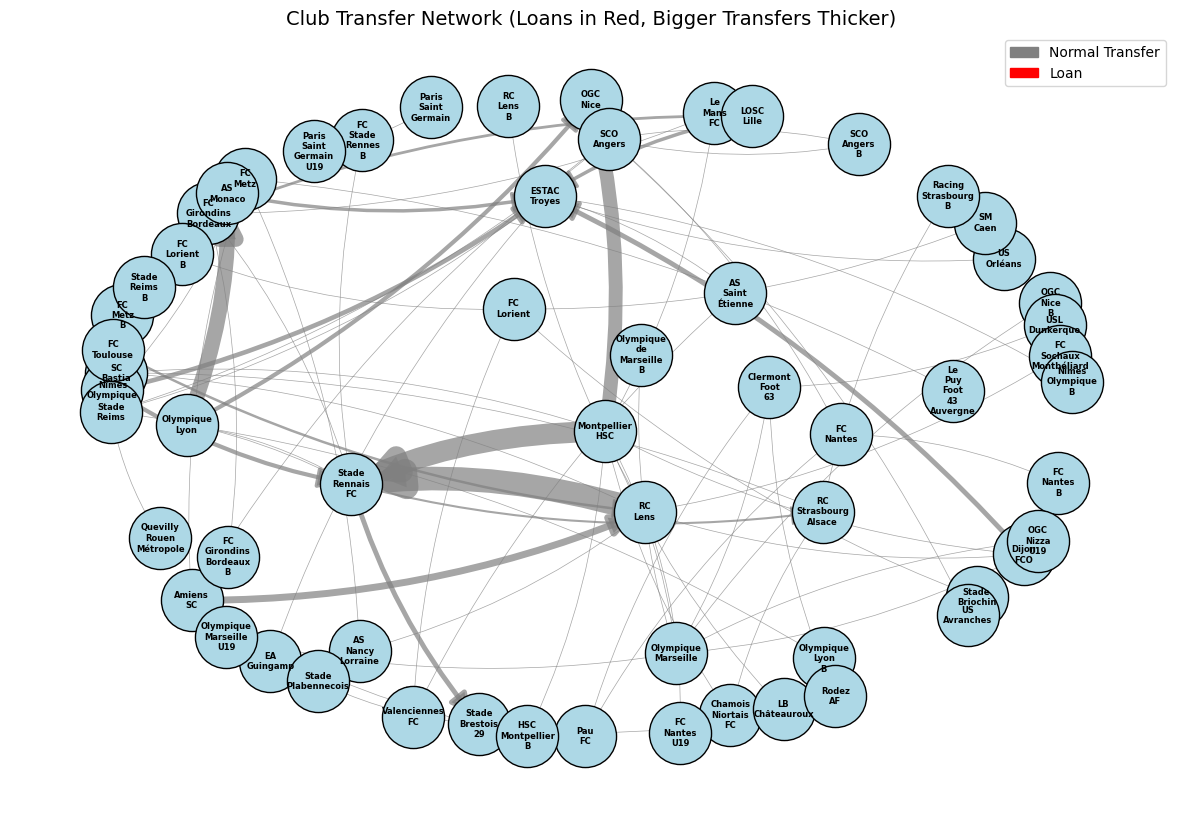

In [8]:
# Visualize the directed sub graph
clubs_to_visualize = df_season[df_season["team_country"] == "France"][
    "team_name"
].unique()

visualize_transfer_network(di_graph, clubs_to_visualize, include_loan=False)